## Exploratory data analysis and Shapley analysis
This notebook contains the exploratory data analysis for merged data collected from the repositories. It expects a file named `data/results/_all_results.csv` to exist, which contains the merged data. This file is created by running the `process_data.py` script with the `--mode=merge` argument.

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_repo_csv(repo_file):
    repo = pd.read_csv(f"data/results/{repo_file}", index_col=0)
    repo['date'] = pd.to_datetime(repo['date'], utc=True)
    return repo

Dataframes for individual repositories.

In [3]:
repo_files = list(set(os.listdir("data/results")) - {"_all_results.csv", "tiny"})

max_repos_load = 5
repos = {repo_file: load_repo_csv(repo_file) for repo_file in repo_files[:max_repos_load]}
repos.keys()

dict_keys(['virtualenv.csv', 'backports_abc.csv', 'py-cpuinfo.csv', 'backoff.csv', 'flask-cors.csv'])

Dataframe for all results.

In [4]:
all_results = pd.read_csv("data/results/_all_results.csv", index_col=0)
all_results['date'] = pd.to_datetime(all_results['date'], utc=True)

all_results.describe()["radon_LOC"]

count    42954.000000
mean      7702.262118
std       8042.572265
min          0.000000
25%       1489.000000
50%       4344.000000
75%      12057.750000
max      45922.000000
Name: radon_LOC, dtype: float64

In [5]:
all_results.head()

,hash,author,date,commit_message,is_merge,lines_changed,insertions,deletions,dmm_unit_size,dmm_unit_complexity,...,radon_avg_cc,radon_avg_MI,radon_avg_vocabulary,radon_avg_length,radon_avg_volume,radon_avg_difficulty,radon_avg_effort,radon_avg_time,radon_avg_bugs,repo_name
ID,,,,,,,,,,,,,,,,,,,,,
0,1c6972eef4d4dc774fa50f29248f776fa6628e9e,Yilei Yang,2017-09-19 21:25:01+00:00,Initial commit: Abseil Python Common Libraries.,False,22843,22843,0,0.544562,0.767955,...,1.956307,65.930709,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
1,e8d3808145a248845098dea839b1ff6753981f18,Yilei Yang,2017-09-25 17:28:32+00:00,Move the --only_check_args check earlier. So ...,False,14,12,2,1.000000,1.000000,...,1.955519,65.918611,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
2,a03c793c3db4d35cac68953c4207e1929881362c,Yilei Yang,2017-09-25 17:29:23+00:00,Fix FLAGS.set_default's docstring. It only se...,False,7,4,3,NaN,NaN,...,1.955519,65.918328,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
3,9b5d766f40f8ff1d2c74c88b95340fdc01a42ef2,Yilei Yang,2017-09-25 17:29:56+00:00,Code cleanup. PiperOrigin-RevId: 169707068,False,5,1,4,NaN,NaN,...,1.955519,65.918655,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py
4,99d72774ba05271cf2aa6d9cf80da8508ae48d59,Yilei Yang,2017-09-25 17:31:47+00:00,Clean up unused code. PiperOrigin-RevId: 1697...,False,15,1,14,1.000000,1.000000,...,1.955519,65.919108,36.338983,59.20339,393.256327,2.797832,3096.346638,172.019258,0.131085,abseil-py


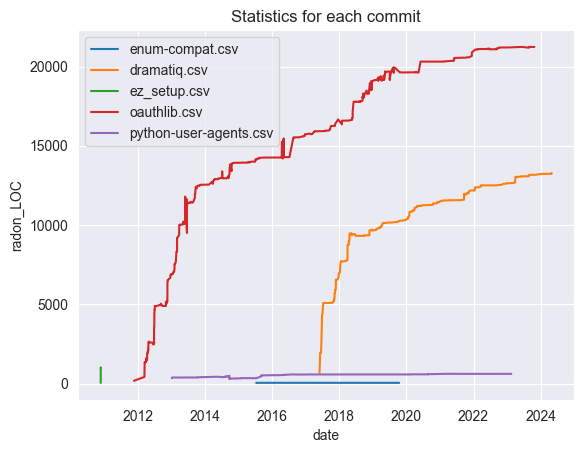

In [6]:

# Sample codebase size throughout time.
for repo_name, df in repos.items():
    sns.lineplot(data=df, x='date', y='radon_LOC', label=repo_name)
plt.title("Statistics for each commit");

In [8]:
# Find rows with lowest and highest value of something.
col = "radon_avg_cc"
all_results.loc[all_results[col].idxmin()], all_results.loc[all_results[col].idxmax()]


(hash                             ac71d6e22754bed5ec6c3ce304ca86e027c88bfb
 author                                                       Jeff Forcier
 date                                            2013-12-07 00:05:17+00:00
 commit_message          Import kennethreitz/requests/docs/_themes @ 9f...
 is_merge                                                            False
 lines_changed                                                        1109
 insertions                                                           1109
 deletions                                                               0
 dmm_unit_size                                                         NaN
 dmm_unit_complexity                                                   NaN
 dmm_unit_interfacing                                                  NaN
 radon_LOC                                                              86
 radon_LLOC                                                              7
 radon_SLOC              

Shapley analysis.

In [22]:
import json

import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import shap

In [23]:
DATA_FILE = "data/results/_all_results.csv"

cols = ["radon_LOC", "radon_LLOC", "radon_SLOC", "radon_comments", "radon_avg_cc", "radon_avg_MI", "radon_avg_vocabulary", "radon_avg_length", "radon_avg_volume", "radon_avg_difficulty", "radon_avg_effort", "radon_avg_time", "radon_avg_bugs"]
data = pd.read_csv(DATA_FILE, usecols=cols)

# Map feature names for readability.
with open("feature-label-map.json", "r") as f:
    feature_label_map = json.load(f)
data.rename(columns=feature_label_map, inplace=True)

y = data["LOC"]
X = data.drop(["LOC", "LLOC", "SLOC", "Comments"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)

# Hyperparameters for the LightGBM model.
lgbm_params = {
    "objective": "regression",
    "metrics": ["rmse", "mape"],
    "verbose": 0
}

model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [24]:
for boost_rounds in range(500, 1000, 100):
    print(f"Boost rounds: {boost_rounds}")
    model = lgb.train(lgbm_params, train_data, num_boost_round=boost_rounds)
    cv_metrics = lgb.cv(lgbm_params, train_data, num_boost_round=boost_rounds)
    for metric, values in cv_metrics.items():
        print(f"mean of '{metric}': {np.mean(values)}")


Boost rounds: 500


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 1580.0550257070922
mean of 'valid rmse-stdv': 50.60647942282443
mean of 'valid mape-mean': 0.6923124895909035
mean of 'valid mape-stdv': 0.034489700876926335
Boost rounds: 600


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 1470.4797538576904
mean of 'valid rmse-stdv': 53.103827053102684
mean of 'valid mape-mean': 0.6352924515545691
mean of 'valid mape-stdv': 0.031210670130444925
Boost rounds: 700


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 1385.579914324514
mean of 'valid rmse-stdv': 55.44659308988356
mean of 'valid mape-mean': 0.5911283896932286
mean of 'valid mape-stdv': 0.02875002373985099
Boost rounds: 800


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 1317.5202956087835
mean of 'valid rmse-stdv': 57.38881504665003
mean of 'valid mape-mean': 0.5555447607791864
mean of 'valid mape-stdv': 0.026947123931327227
Boost rounds: 900


C:\Users\msmar\msro\metric-dynamics\.venv\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


mean of 'valid rmse-mean': 1261.3483402692123
mean of 'valid rmse-stdv': 59.09260222748487
mean of 'valid mape-mean': 0.5262087942843344
mean of 'valid mape-stdv': 0.025574823276297863


In [25]:
# Testing
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
rmse = root_mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
mape = mean_absolute_percentage_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r2)

Mean Squared Error: 521075.0754931968
Root Mean Squared Error: 721.8553009386277
Mean Absolute Error: 380.7232098840841
Mean Absolute Percentage Error: 341046944687552.6
R-squared: 0.9917604862985768


In [26]:
sns.set_theme(rc={'figure.figsize':(16,9)})

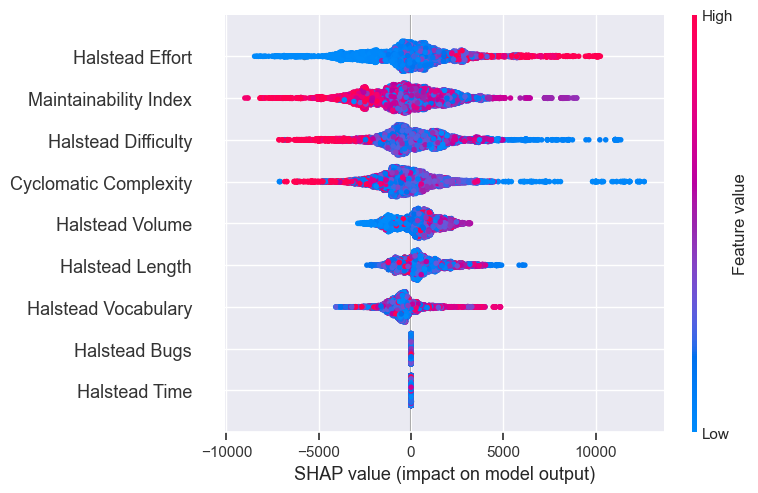

In [27]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [28]:
shap_values_from_explainer = explainer(X_test)

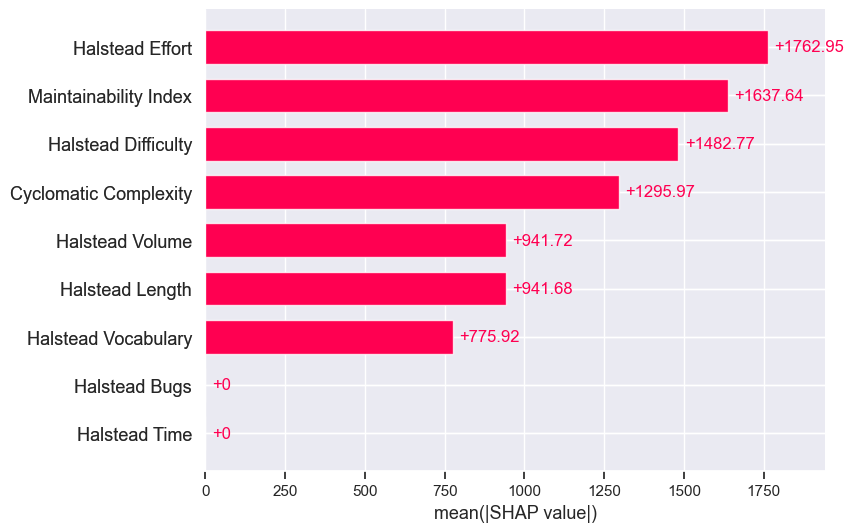

In [29]:
shap.plots.bar(shap_values_from_explainer)

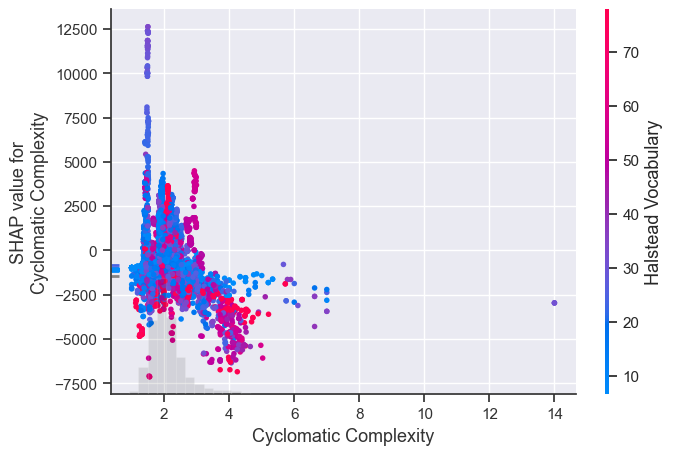

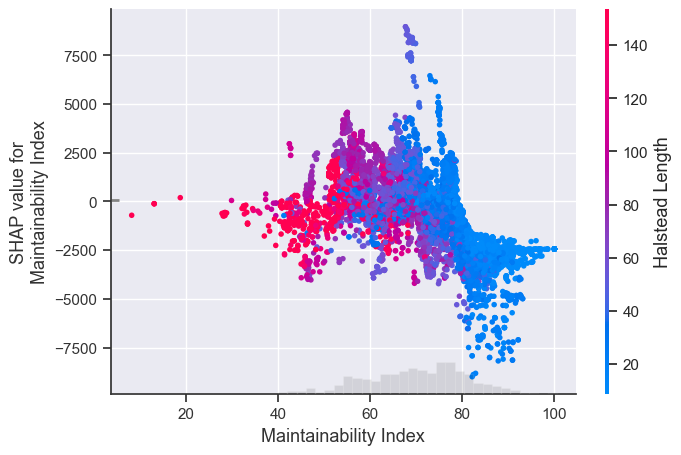

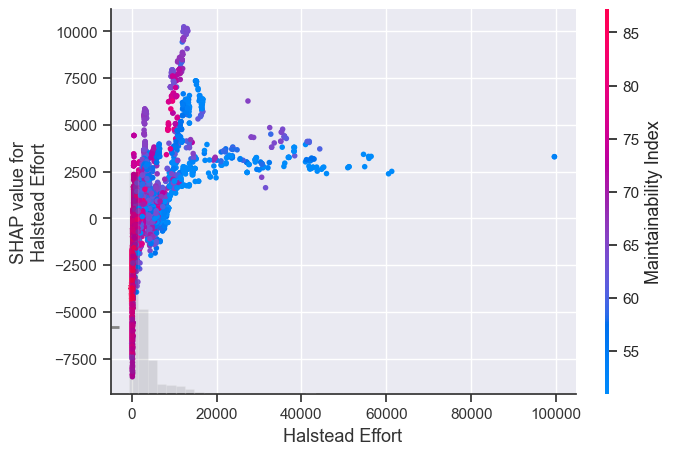

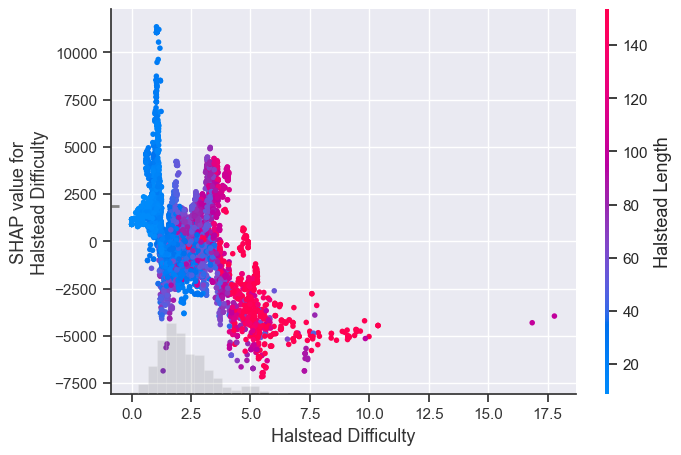

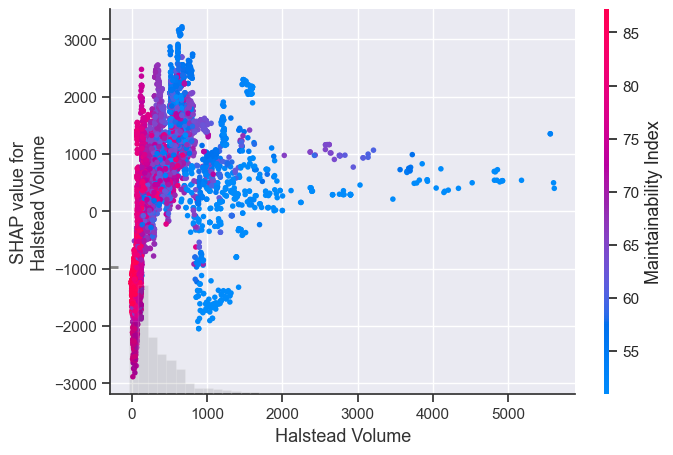

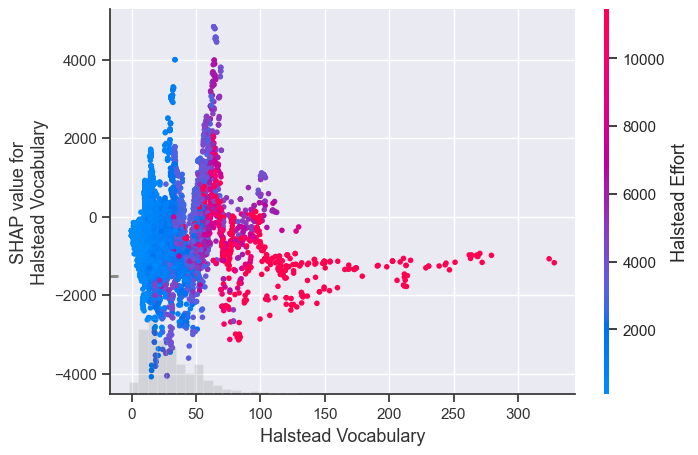

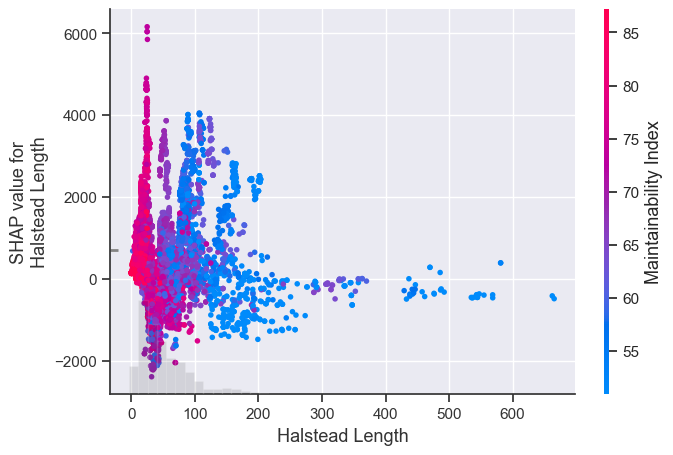

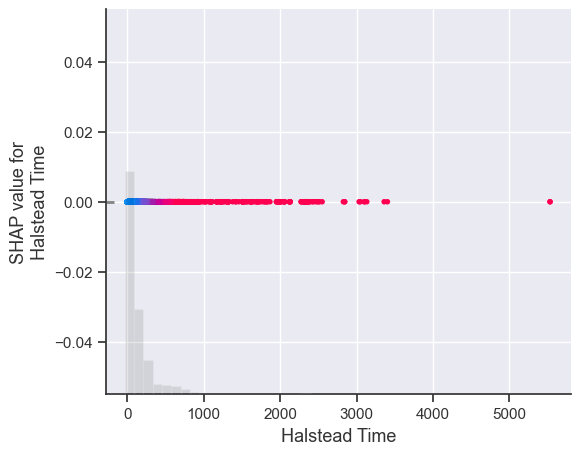

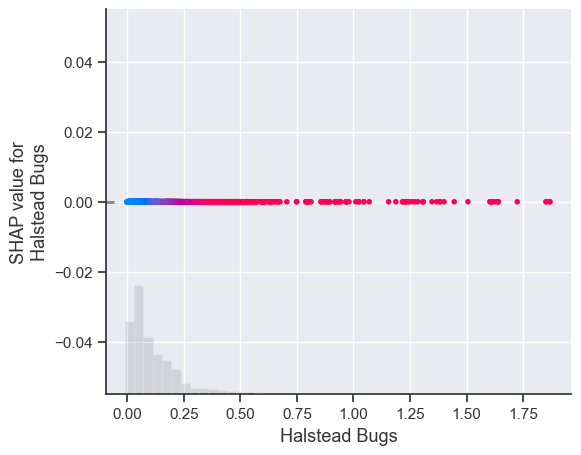

In [34]:
# Dependence plot for specific feature.
features = ["Cyclomatic Complexity", "Maintainability Index", "Halstead Effort", "Halstead Difficulty", "Halstead Volume", "Halstead Vocabulary", "Halstead Length", "Halstead Time", "Halstead Bugs"]
for feature in features:
    # shap.dependence_plot(feature, shap_values, X_test, interaction_index=None)
    shap.plots.scatter(shap_values_from_explainer[:, feature], color=shap_values_from_explainer)

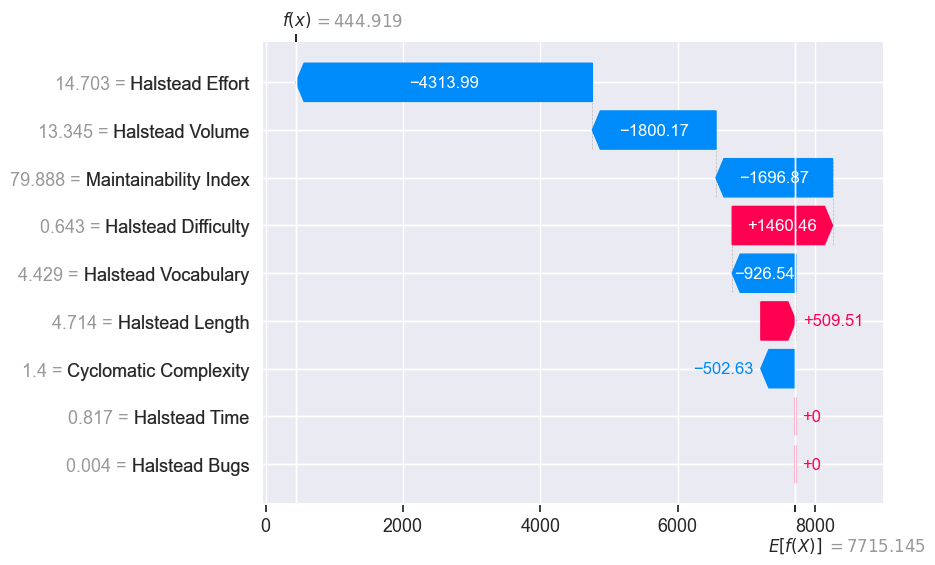

In [31]:
shap.plots.waterfall(shap_values_from_explainer[1])

<Axes: xlabel='LOC'>

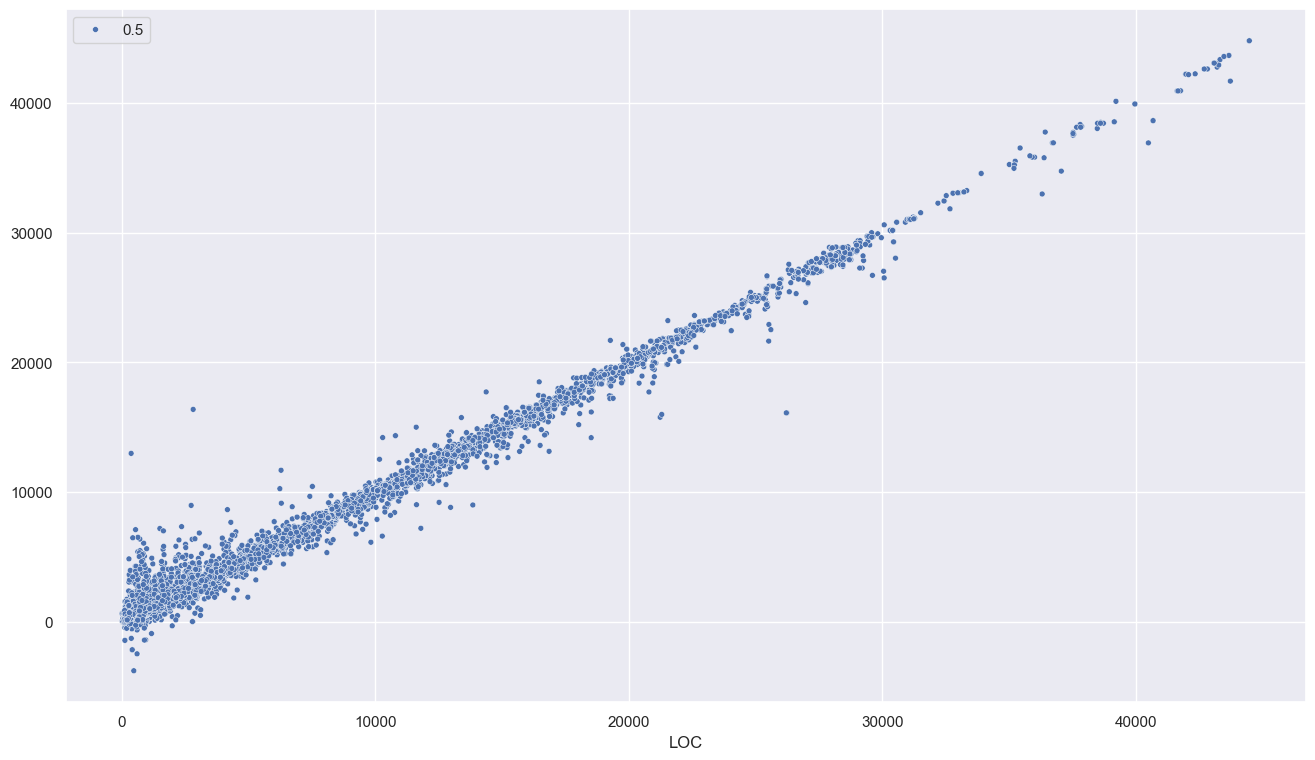

In [32]:
sns.scatterplot(x=y_test, y=y_pred_test, size=0.5)